In [316]:
import pandas as pd
import numpy as np
import warnings
# Reproducibility
import random
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Stats to get trend
from statsmodels.tsa.seasonal import seasonal_decompose

# scikit-learn 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
# Tensorflow (for LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)


# Import data

In [317]:
path = r"C:/Users/TurnerJosh/Desktop/SensitiveData/GoodSalesData1.xlsx"
df = pd.read_excel(path)

In [318]:
df.columns

Index(['Charge Type', 'Order Type', 'Sales Invoice Count', 'Charge Amount',
       'COGS Amount', 'Cost Adjustment Amount', 'Cost Amount',
       'Discount Amount', 'Invoice Amount', 'Invoice Date'],
      dtype='object')

In [319]:
df = df[['Charge Amount','Invoice Date']].loc[df['Charge Amount'] != 0]
# Rename date series 'ds' and time series 'ts'
DF = df.rename(columns = {'Invoice Date': 'ds', 'Charge Amount': 'ts'})

In [320]:
DF.isna().sum()


ts    0
ds    0
dtype: int64

# Initial Analysis

<Axes: xlabel='ds'>

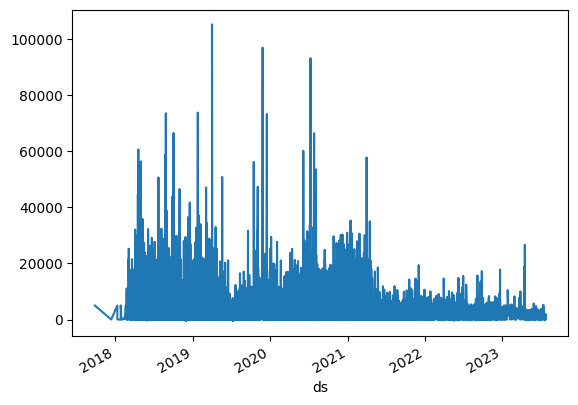

In [321]:
#Choose Time series
df1 = DF.copy()
df1.set_index('ds',inplace=True)
df1['ts'].plot()

# Dealing with outliers

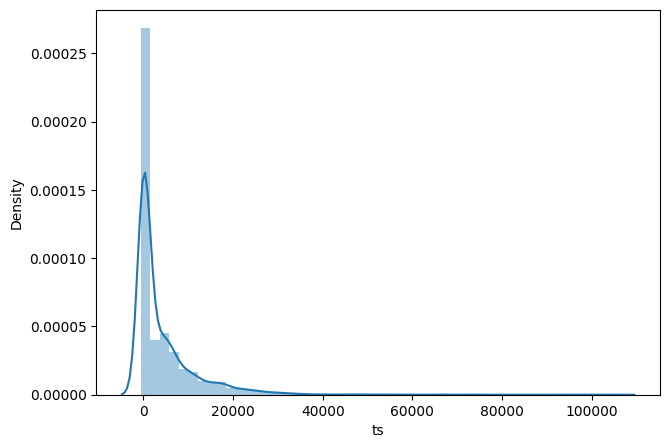

In [322]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(DF['ts'])
# plt.subplot(1,2,2)
# sns.distplot(df[''])
plt.show()

In [323]:
print("Highest allowed",DF['ts'].mean() + 3*DF['ts'].std())
print("Lowest allowed",DF['ts'].mean() - 3*DF['ts'].std())

Highest allowed 27195.618026172233
Lowest allowed -18596.85709070233


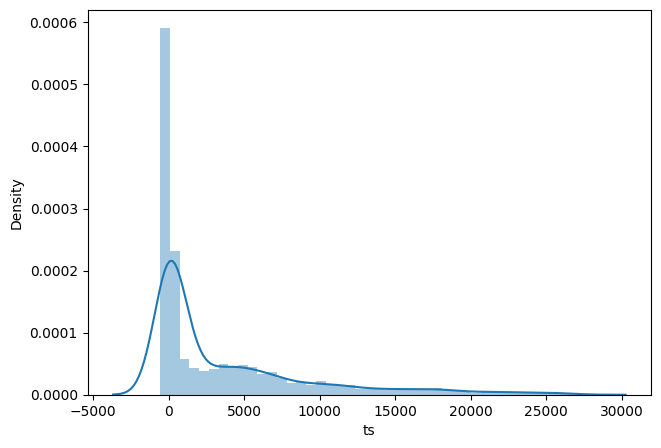

In [324]:
#Trim Outliers
new_df = DF["ts"][(DF['ts'] < DF['ts'].mean() + 3*DF['ts'].std()) & (DF['ts'] > DF['ts'].mean() - 3*DF['ts'].std())]
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(new_df)
# plt.subplot(1,2,2)
# sns.distplot(df[''])
plt.show()

# Dealing with Data Skew

In [325]:
new_df.skew()

1.8565656873251601

In [326]:
# Calculate logarithm to base 2 
# on 'Salary' column
new_df_log = np.log(new_df)
new_df_log.skew()

-0.2735044247691736

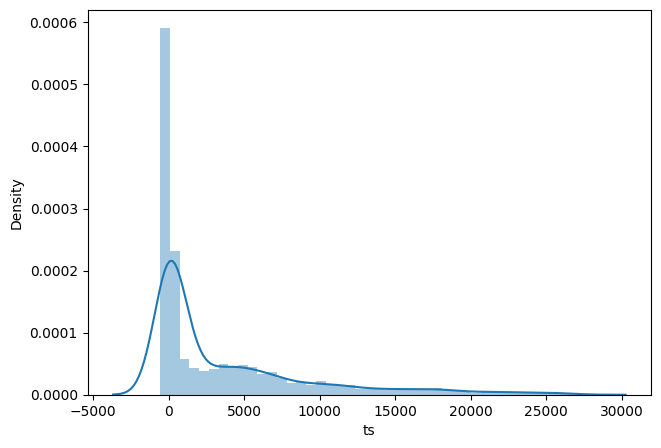

In [370]:

warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(new_df)
plt.show()

In [371]:
new_df.mean()

3677.0977973568283

# Time Series Model

In [328]:
# Copy dataframe
DF['log_Sum_Unit_Price'] = np.log(DF['ts'])
DF = DF.copy()

In [329]:
# Drop nans
DF.dropna(inplace=True)

# Seasonal Decomposition

In [330]:
decomposition = seasonal_decompose(DF['log_Sum_Unit_Price'], period = 30, extrapolate_trend = 'freq')

In [331]:
Decom_Df = DF
Decom_Df.loc[:, "trend"] = decomposition.trend
Decom_Df.loc[:, "seasonal"] = decomposition.seasonal
Decom_Df.loc[:, "residual"] = decomposition.resid

In [332]:
# Merge the 'Trend' column back into the original DataFrame
DF['trend'] = Decom_Df['trend']
DF.head(5)

,ts,ds,log_Sum_Unit_Price,trend,seasonal,residual
1,60058,2020-06-06,11.003066,10.137908,0.076169,0.788989
3,35185,2021-01-15,10.468375,10.133093,-0.061160,0.396442
5,27303,2020-11-10,10.214752,10.128279,0.080363,0.006111
8,30302,2021-01-19,10.318969,10.123464,0.126111,0.069395
9,21154,2021-04-19,9.959584,10.118649,0.104637,-0.263702


In [333]:
# After performing seasonal decomposition, reset the index
Decom_Df = Decom_Df.reset_index(drop=True)

In [334]:
def plot_decomposition(df, ts,trend,seasonal, residual):
## Make into time axis
  f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15, 5), sharex = True)

  ax1.plot(df[ts], label = 'Original', c = 'b')
  ax1.legend(loc = 'best')
  ax1.tick_params(axis = 'x', rotation = 45)

  ax2.plot(df[trend], label = 'Trend', c = 'lime')
  ax2.legend(loc = 'best')
  ax2.tick_params(axis = 'x', rotation = 45)

  ax3.plot(df[seasonal],label = 'Seasonality', c = 'm')
  ax3.legend(loc = 'best')
  ax3.tick_params(axis = 'x', rotation = 45)

  ax4.plot(df[residual], label = 'Residuals', c = 'r')
  ax4.legend(loc = 'best')
  ax4.tick_params(axis = 'x', rotation = 45)
  plt.tight_layout()

  #plt.subtitle('Signal Decomposition of  %s' %(ts), x =0.5, y= 1.05, fontsize = 18)
  plt.show()

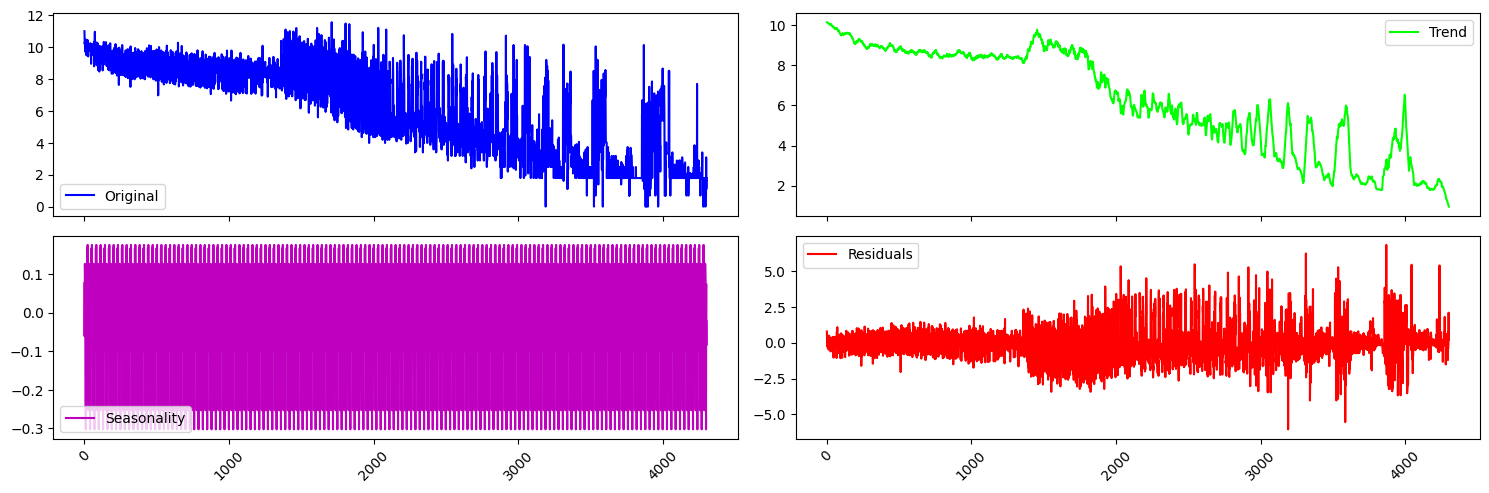

In [335]:
plot_decomposition(Decom_Df, ts = 'log_Sum_Unit_Price', trend = 'trend', seasonal = 'seasonal', residual = 'residual')

# Subtracting out the trend

<Axes: >

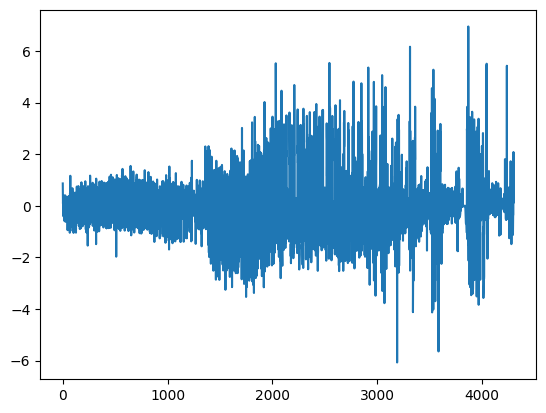

In [337]:
Decom_Df['No_Trend'] = Decom_Df.log_Sum_Unit_Price - Decom_Df.trend
Decom_Df.No_Trend.plot()
# Decom_Df.ts.plot()

# Apply different model on ts with trend subtracted

# An LSTM

## Data Prep

In [338]:
# Prepare time series for LSTM 
Decom_Df.sort_values('ds',inplace=True)
# Decom_Df.sort_index()

In [339]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
Decom_Df['No_Trend'] = scaler.fit_transform(Decom_Df[['No_Trend']])

In [340]:
# Create sequences of fixed length (e.g., 30 time steps)
sequence_length = 30

X, y = [], []
for i in range(len(Decom_Df) - sequence_length):
    X.append(Decom_Df['No_Trend'].iloc[i:i + sequence_length])
    y.append(Decom_Df['No_Trend'].iloc[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
y.shape

(4273,)

## Training and Testing Sets

In [341]:
X_train,y_train,X_test,y_test = X[:int(0.8*len(X))],y[:int(0.8*len(X))],X[int(0.8*len(X)):],y[int(0.8*len(X)):]

## Model Architecture

In [342]:
# Create LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(5))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

## Model Training

In [343]:
# Train Model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))


Epoch 1/50


107/107 [==============================] - 4s 18ms/step - loss: 0.0335 - val_loss: 0.0058
Epoch 2/50
107/107 [==============================] - 1s 14ms/step - loss: 0.0082 - val_loss: 0.0054
Epoch 3/50
107/107 [==============================] - 1s 13ms/step - loss: 0.0082 - val_loss: 0.0055
Epoch 4/50
107/107 [==============================] - 1s 13ms/step - loss: 0.0082 - val_loss: 0.0056
Epoch 5/50
107/107 [==============================] - 1s 13ms/step - loss: 0.0082 - val_loss: 0.0049
Epoch 6/50
107/107 [==============================] - 1s 13ms/step - loss: 0.0082 - val_loss: 0.0068
Epoch 7/50
107/107 [==============================] - 1s 14ms/step - loss: 0.0082 - val_loss: 0.0051
Epoch 8/50
107/107 [==============================] - 1s 14ms/step - loss: 0.0082 - val_loss: 0.0047
Epoch 9/50
107/107 [==============================] - 1s 13ms/step - loss: 0.0082 - val_loss: 0.0050
Epoch 10/50
107/107 [==============================] - 1s 13ms/step - loss: 0.0083 - val_loss: 0.0044


## Model Predictions

In [344]:
# make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

27/27 [==============================] - 0s 5ms/step


# Add Trend Back in

In [346]:
# Add in trend
trend_values = Decom_Df['trend'].values
# Calculate the trend values corresponding to the train and test sets
# trend_test = trend_values[int(0.8 * len(X)):].reshape(-1,1)
trend_train = trend_values[:len(Decom_Df) - sequence_length]
trend_train = trend_train[:int(0.8 * len(X))].reshape(-1,1)
trend_test = trend_values[sequence_length:]
trend_test = trend_test[int(0.8 * len(X)):].reshape(-1,1)

In [353]:

# Training predictions
y_train_pred1 = trend_train.reshape(-1,1) + y_train_pred
y_train_pred1.shape

# y_train_pred1 = np.exp(scaler.inverse_transform(y_train_pred1))
# y_test_pred1 =  np.exp(scaler.inverse_transform(y_test_pred1))

(3418, 1)

In [355]:
# Testing Predictions
y_test_pred1 = trend_test.reshape(-1,1) + y_test_pred
y_test_pred1.shape

(855, 1)

In [303]:
# Inverse transform the predictions to put in terms of sales (no log)
# y_train_pred = scaler.inverse_transform(y_train_pred)
# y_test_pred = scaler.inverse_transform(y_test_pred)

In [305]:
# Time Values
# time_values = Decom_Df['ds'].values
# time_values = time_values[sequence_length:]
# time_values = time_values[int(0.8 * len(X)):]

# Actuals

In [360]:
# Actuals
# y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
# y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [366]:
# # Calculate the trend values corresponding to the train and test sets
actuals = Decom_Df['ts'].values
# trend_test = trend_values[int(0.8 * len(X)):].reshape(-1,1)
y_train_actuals = actuals[:int(0.8 * len(X))]
y_train_actuals = y_train_actuals.reshape(-1, 1)

y_test_actuals = actuals[sequence_length:]
y_test_actuals = y_test_actuals[int(0.8 * len(X)):]
y_test_actuals = y_test_actuals.reshape(-1, 1)

In [367]:
y_train_actuals.shape,y_test_actuals.shape

((3418, 1), (855, 1))

## Evaluation of Model Performance

In [373]:
# Evaluate Model
train_rmse = np.sqrt(mean_squared_error(y_train_actuals, y_train_pred1))
test_rmse = np.sqrt(mean_squared_error(y_test_actuals, y_test_pred1))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 9967.205702890107
Test RMSE: 4048.4890892486137


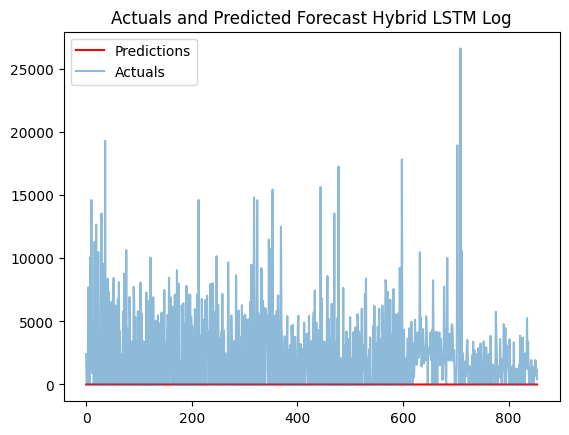

In [374]:
plt.plot(y_test_pred,c='red',label='Predictions')
plt.title('Actuals and Predicted Forecast Hybrid LSTM Log')
plt.plot(y_test_actuals,label='Actuals',alpha=0.5)
# plt.scatter(y_test_pred,y_test_actuals)
plt.legend()
plt.show()

In [314]:
# R2
r2_score(y_test_actuals, y_test_pred)

-0.217646367832514

In [66]:
DF.ds.iloc[int(0.8 * len(X)):].values

array(['2019-06-27T00:00:00.000000000', '2019-07-30T00:00:00.000000000',
       '2019-08-30T00:00:00.000000000', '2019-09-13T00:00:00.000000000',
       '2019-11-26T00:00:00.000000000', '2019-12-18T00:00:00.000000000',
       '2019-12-23T00:00:00.000000000', '2020-02-24T00:00:00.000000000',
       '2020-08-07T00:00:00.000000000', '2019-07-13T00:00:00.000000000',
       '2020-03-24T00:00:00.000000000', '2020-05-08T00:00:00.000000000',
       '2020-06-03T00:00:00.000000000', '2018-05-31T00:00:00.000000000',
       '2021-11-08T00:00:00.000000000', '2021-11-10T00:00:00.000000000',
       '2021-11-16T00:00:00.000000000', '2021-11-24T00:00:00.000000000',
       '2023-05-11T00:00:00.000000000', '2023-05-18T00:00:00.000000000',
       '2023-05-25T00:00:00.000000000', '2023-05-26T00:00:00.000000000',
       '2023-06-06T00:00:00.000000000', '2023-06-12T00:00:00.000000000',
       '2023-07-12T00:00:00.000000000', '2023-07-13T00:00:00.000000000',
       '2023-07-14T00:00:00.000000000', '2023-07-24

# XGBoost Model